# Denoising timeseries data by using WaveletBuffer

A popular approach for conditional monitoring of mechanical machines is to embed vibration sensors into a machine and start "listening" to it. The data from
the sensors must be stored somewhere. So, the more efficient we compress them, the longer history we can keep. When we deal with sensors we always have noise from them, and when a machine is stopped we have only noise which wastes our storage space. [WaveletBuffer][2] was developed to solve this problem by using the wavelet transformation and efficient compression of denoised data. However, a user must know many settings to use it efficiently. In this tutorial you will learn how to find denoising parameters to get rid of white noise in your data.

## Basics

For an educational purpose, I brought two samples from a vibration sensor which is maintained on a real machine. You can find them in the directory `docs/tutorilas`. `buffer_signal.bin` contains a second of the signal when the machine is working. `buffer_no_signal.bin` has only noise, because the machine is stopped. Both files are serialized buffer without any denoising, so they have equal sizes but different amount of the information!

We need to separate white nose and information, so we need the sample with the working machine. Let's deserialize it:

In [1]:
from wavelet_buffer import WaveletBuffer, denoise
import numpy as np
import matplotlib.pyplot as plt

blob = b""
with open("buffer_signal.bin", "rb") as f:
    blob = f.read()

print(f"Initial size {len(blob)/ 1000} kB")
buffer = WaveletBuffer.parse(blob)
print(buffer)

Initial size 194.918 kB
WaveletBuffer<signal_number=1, signal_shape=(48199), decomposition_steps=9, wavelet_type=WaveletType.DB3>


You can see that the signal has about 48000 points and the size of the file is about 200kB. Let's have a look at the signal inside:

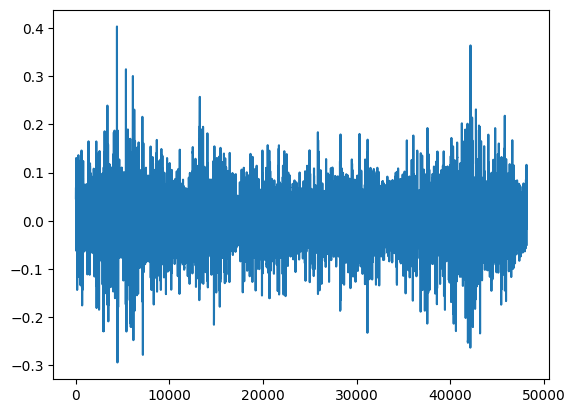

In [2]:
signal = buffer.compose()

plt.plot(signal)
plt.show()

Looks noisy, right? When we've restored the original signal, we can use WaveletBuffer to denoise it. We use some random threshold for the demonstration. Later we learn how to find the optimal parameter.
When we pass `denoise.Threshold(a=0, b=0.04)` in `WaveletBuffer.decompose` method it set to 0 all values in hi-frequency subbands which less than a*x+b where x is a decomposition step of the current subband.

In [ ]:
buffer.decompose(
    signal, denoise.Threshold(a=0, b=0.04)
)  # this a*x + 0.04 where x is a decomposition step
denoised = buffer.compose()
plt.plot(denoised)
plt.show()

The denoised signal looks the same, but we actually don't know if we removed only the noise, or we remove some part of the signal.
To figure out, it we can take the difference between the denoised and original signals and check if it has some information or only noise. It it has some information and means we deleted with denoising.

In [ ]:
err = denoised - signal
plt.plot(err)
plt.show()

To check if the difference (err) has something more than only noise we can use find autocorrelation of error and test if all the values liew within `[-1.96/sqrt(n), 1.96.sqrt(n)]` where n is the size of sample. For more detail, see [here][1].

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode="full")
    return result[int(len(result) / 2) :]


def test(corr: np.ndarray):
    thr = 1.96 / np.sqrt(len(corr))
    tests = np.where(np.abs(corr) <= thr, 1, 0)
    return (tests.sum() / len(corr)) >= 0.95


corr = autocorr(err)
print(test(corr))

You can see that for `denoise.Threshold(0, 0.04)` we removed something important from our signal. However, the desnoised signal looked the same.
To fine the optimal threshold, we can start from 0 and increasing the threshold with a little step until we fail the test:

In [ ]:
threshold = 0
step = 0.0001
for x in range(1000):
    threshold = step * x
    buffer.decompose(signal, denoise.Threshold(0, threshold))
    err = buffer.compose() - signal
    corr = autocorr(err)
    if not test(corr):
        threshold = threshold - step
        print(f"Optimal threshold: {threshold}")
        break

You see that the threshold way less than our initial assumption. Let's check the size of serialized signal:

In [ ]:
buffer.decompose(signal, denoise.Threshold(0, threshold))
print(f"Compression size: {len(buffer.serialize(compression_level=16)) / 1000} kB")

signal = buffer.compose()

plt.plot(signal)
plt.show()

Looks like it got 6 times smaller after the demonising. However, the most interesting thing is compression of the sample when the machine was stopped:

In [ ]:
blob = b""
with open("buffer_no_signal.bin", "rb") as f:
    blob = f.read()

buffer = WaveletBuffer.parse(blob)
buffer.decompose(buffer.compose(), denoise.Threshold(0, threshold))
signal = buffer.compose()

print(
    f"Compression (onlynoise) size: {len(buffer.serialize(compression_level=16)) / 1000} kB"
)

plt.plot(signal)
plt.show()

The compressed size is 500 times smaller now, because we don't have valuable information in the sample.

## Conclusion

[WaveletBuffer][1] provides a pipline `wavelet transormation` -> `denoising` -> `compression` which is useful for efficient compression of height frequency timeseries data. This approach has an additional advantage for data sources which don't provide valuable information all the time but are requested continuously.

## References:

* [White Noise Model][1]
* [WaveletBuffer][2]


[1]:https://timeseriesreasoning.com/contents/white-noise-model/
[2]:https://github.com/panda-official/WaveletBuffer